In [1]:
import pickle
import arrayfire as af

weights_dict = pickle.load(open("./weights_dict.pkl", "rb"))

# module == module_input -> norm -> conv2d -> module_out
module_input = af.array.read_array("OUTPUT.arr", key="model_input").to_ndarray()
input_conv2d = af.array.read_array("OUTPUT_CONV2D.arr", key="input_conv2d").to_ndarray()
module_out = af.array.read_array("OUTPUT.arr", key="conv_output").to_ndarray()
normw = weights_dict["Conv2D_normw"]
normb = weights_dict["Conv2D_normb"]
def valueprint(arr, key=None):
    print(key, arr.shape, arr.sum())

In [2]:
valueprint(module_input, "module_input")
valueprint(input_conv2d, "input_conv2d")
valueprint(module_out, "module_out")
valueprint(normw, "normw")
valueprint(normb, "normb")

module_input (961, 80) -0.0029907227
input_conv2d (961, 1, 80) -11299.283
module_out (1536, 321) 330.57333
normw (1,) 0.5960634
normb (1,) -0.14697292


In [3]:
import torch
import numpy as np
from transformers import MCTCForCTC, MCTCProcessor, MCTCConfig
from datasets import load_dataset, load_metric, Audio, Dataset

config = MCTCConfig()
model = MCTCForCTC(config)
model.load_state_dict(torch.load("./ported_pytorch_model.bin"))

<All keys matched successfully>

In [4]:
first_layer_norm = model.mctc.encoder.layer_norm.eval()
first_layer_conv = model.mctc.encoder.conv.eval()

In [5]:
input_conv2d_tensor = torch.Tensor(input_conv2d).squeeze(dim=1).unsqueeze(0) # batched
valueprint(input_conv2d_tensor, "input_conv2d_tensor")

input_conv2d_tensor_padded = torch.nn.functional.pad(input_conv2d_tensor, (0,0,3,3), "constant", 0)

model_conv_output = first_layer_conv(input_conv2d_tensor_padded)
print("model_conv_output", model_conv_output.shape, model_conv_output.sum())

input_conv2d_tensor torch.Size([1, 961, 80]) tensor(-11299.2832)
model_conv_output torch.Size([1, 321, 1536]) tensor(330.5733, grad_fn=<SumBackward0>)


In [6]:
# conv works correctly!!!!!

In [7]:
norm_input = torch.Tensor(module_input)
norm_output = torch.Tensor(input_conv2d)
valueprint(norm_input, "norm_input")
valueprint(norm_output, "norm_output")

norm_input torch.Size([961, 80]) tensor(-0.0034)
norm_output torch.Size([961, 1, 80]) tensor(-11299.2832)


In [8]:
model_norm_output = first_layer_norm(norm_input)
valueprint(model_norm_output, "model_norm_output")

model_norm_output torch.Size([961, 80]) tensor(-11299.3154, grad_fn=<SumBackward0>)


In [9]:
valueprint(module_input, "module_input")
valueprint(input_conv2d, "input_conv2d")
valueprint(module_out, "module_out")

module_input (961, 80) -0.0029907227
input_conv2d (961, 1, 80) -11299.283
module_out (1536, 321) 330.57333


In [10]:
first_layer_norm = model.mctc.encoder.layer_norm.eval()
first_layer_conv = model.mctc.encoder.conv.eval()

def pad(input_conv2d_tensor):
    return torch.nn.functional.pad(input_conv2d_tensor, (0,0,3,3), "constant", 0)

model_norm_out = first_layer_norm(torch.Tensor(module_input).unsqueeze(0))
valueprint(model_norm_out, "norm_out")
model_norm_out = model_norm_out.squeeze(0)

model_out = pad(model_norm_out.unsqueeze(0))
valueprint(model_out, "padded_out")
model_out = first_layer_conv(model_out)
valueprint(model_out, "model_out")

norm_out torch.Size([1, 961, 80]) tensor(-11299.3154, grad_fn=<SumBackward0>)
padded_out torch.Size([1, 967, 80]) tensor(-11299.3154, grad_fn=<SumBackward0>)
model_out torch.Size([1, 321, 1536]) tensor(-386.8117, grad_fn=<SumBackward0>)


In [11]:
real_norm_out = input_conv2d
model_norm_out = model_norm_out
valueprint(real_norm_out, "real_norm_out")
valueprint(model_norm_out, "model_norm_out")

real_norm_out (961, 1, 80) -11299.283
model_norm_out torch.Size([961, 80]) tensor(-11299.3154, grad_fn=<SumBackward0>)


In [12]:
real_norm_out = torch.Tensor(real_norm_out).squeeze(1)
model_norm_out = model_norm_out.squeeze(0)

diff = real_norm_out - model_norm_out
valueprint(diff, "diff")

diff torch.Size([961, 80]) tensor(0.0312, grad_fn=<SumBackward0>)


<Figure size 432x720 with 0 Axes>

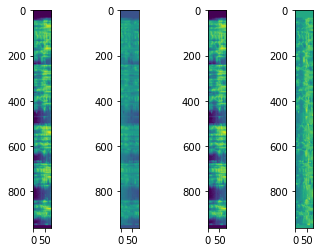

In [13]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(6, 10))


fig, axs = plt.subplots(1, 4)
# fig.suptitle('Vertically stacked subplots')
# axs[0].plot(x, y)
# axs[1].plot(x, -y)

axs[0].imshow(module_input)
axs[1].imshow(diff.detach().numpy())
axs[2].imshow(real_norm_out.detach().numpy())
axs[3].imshow(model_norm_out.detach().numpy())

None (961, 80) -0.0029907227
ll (961, 80) -11299.279
real_norm_out torch.Size([961, 80]) tensor(-11299.2832)
tensor(0.0030)


<Figure size 432x720 with 0 Axes>

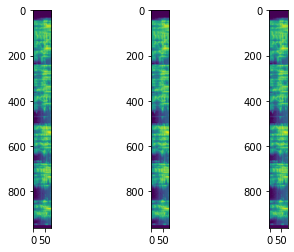

In [14]:
valueprint(module_input)
ll = module_input*normw + normb
valueprint(ll, "ll")
valueprint(real_norm_out, "real_norm_out")

fig = plt.figure(figsize=(6, 10))


fig, axs = plt.subplots(1, 3)
axs[0].imshow(module_input)
axs[1].imshow(ll)
axs[2].imshow(real_norm_out.detach().numpy())

diff = torch.Tensor(ll) - real_norm_out
print(diff.sum())

In [17]:

model_norm_out = torch.Tensor(ll)

model_out = pad(model_norm_out.unsqueeze(0))
valueprint(model_out, "padded_out")
model_out = first_layer_conv(model_out)
valueprint(model_out, "model_out")

padded_out torch.Size([1, 967, 80]) tensor(-11299.2793)
model_out torch.Size([1, 321, 1536]) tensor(330.5749, grad_fn=<SumBackward0>)


In [1]:
# testing after fixing the model & weights
import torch
from transformers import MCTCForCTC, MCTCProcessor, MCTCConfig
config = MCTCConfig()
model = MCTCForCTC(config)
model.load_state_dict(torch.load("./ported_pytorch_model.bin"))

<All keys matched successfully>

In [2]:
import arrayfire as af
module_input = af.array.read_array("OUTPUT.arr", key="model_input").to_ndarray()
input_conv2d = af.array.read_array("OUTPUT_CONV2D.arr", key="input_conv2d").to_ndarray()
module_out = af.array.read_array("OUTPUT.arr", key="conv_output").to_ndarray()
def valueprint(arr, key=None):
    print(key, arr.shape, arr.sum())

valueprint(module_input)
valueprint(module_out)

None (961, 80) -0.0029907227
None (1536, 321) 330.57333


In [6]:
'''
def forward(
    self,
    input_features,
    attention_mask,
    head_mask,
    output_attentions=False,
    output_hidden_states=False,
    return_dict=True,
):
    output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
    output_hidden_states = (
        output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
    )
    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    input_features = self.layer_norm(input_features)
    
    inputs_embeds = self.conv(input_features)
'''
model.eval()

input_features = torch.Tensor(module_input).unsqueeze(0)
valueprint(input_features, "input_features")
our_output = model.mctc.encoder.layer_norm(input_features)
valueprint(input_conv2d, "input_conv2d")
valueprint(our_output, "our_input_conv2d")
our_output = model.mctc.encoder.conv(our_output)
valueprint(our_output, "our_output")
valueprint(module_out, "desired output")

input_features torch.Size([1, 961, 80]) tensor(-0.0034)
input_conv2d (961, 1, 80) -11299.283
our_input_conv2d torch.Size([1, 961, 80]) tensor(-11299.2812, grad_fn=<SumBackward0>)
input_features torch.Size([1, 967, 80]) tensor(-11299.2793, grad_fn=<SumBackward0>)
our_output torch.Size([1, 321, 1536]) tensor(330.5749, grad_fn=<SumBackward0>)
desired output (1536, 321) 330.57333


In [7]:
# done!